# AI Algoithms - Final Project
By: Tejas Vyas

## Scam job classification using NLP and Machine Learning

**Feature Engineering and Exploratory data analysis (EDA) available in the Data Acquisition and Understanding folder**

## Loading and pre-processing
Let's start by loading all necessary libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score 
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import tree, svm
from sklearn.ensemble import RandomForestClassifier
from pandas.plotting import scatter_matrix

Our data is contained in fake_job_postings.csv, reading and verifying its loaded properly

In [2]:
# fake_job_postings.csv is our data file - loading it into pandas an verifying its loaded correctly
df = pd.read_csv('fake_job_postings.csv')
print("Data shape - ",df.shape)
df.head(3)

Data shape -  (17880, 18)


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0


We need to check if the data contains any null values so we can clean it up

In [3]:
df = df.drop(columns=['job_id'])

In [4]:
text_df = df[["title", "company_profile", "description", "requirements", "benefits","fraudulent"]]
text_df = text_df.fillna(' ')

text_df.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


In [5]:
data = pd.DataFrame(columns=['text','target'])
data.text = text_df[text_df.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
data.target = df['fraudulent']

import string
def remove_punct(text):
  text_nopunct= "".join ([char for char in text if char not in string.punctuation])
  return text_nopunct
data.text=data.text.apply(lambda x:remove_punct(x))

import re
def tokenize(text):
  tokens = re.split('\W+', text)
  return tokens
data.text=data.text.apply(lambda x: tokenize(x.lower()))

import nltk
#nltk.download('stopwords')

stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(tokenized_list):
  text = [word for word in tokenized_list if word not in stopword]
  return text
def join_text(text):
    joined_text = ' '.join(text)
    return joined_text

data.text=data.text.apply(lambda x: remove_stopwords(x))
data.text=data.text.apply(lambda x : join_text(x))
data.head()

,text,target
0,marketing internwere food52 weve created groun...,0
1,customer service cloud video production90 seco...,0
2,commissioning machinery assistant cmavalor ser...,0
3,account executive washington dcour passion imp...,0
4,bill review managerspotsource solutions llc gl...,0


## Test train split and vectorization

Because of the features, the memory requirement for this dataset is very high, thus in order to prototype, we'll limit the set to a sample of top 3000

In [6]:
from sklearn import linear_model, model_selection
from sklearn.feature_extraction.text import TfidfVectorizer

# Import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit

# Set the split criteria
split = StratifiedShuffleSplit(n_splits=1, test_size=3000)

# Perform data frame split
for x, y in split.split(data, data.target):
    stratified_random_sample = data.iloc[y]

sentences_train, sentences_test, y_train, y_test = model_selection.train_test_split(stratified_random_sample.text, stratified_random_sample.target, test_size=0.25, random_state=0)
#print(sentences_train)
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(stratified_random_sample.text)
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train_arr = X_train.toarray()
X_test_arr = X_test.toarray()

### Training on Random Forest

In [7]:
rf = RandomForestClassifier()
rf.fit(X_train_arr, y_train)
rfscore = rf.score(X_test_arr, y_test)

### Training on Logistic Regression

In [8]:
logRes = LogisticRegression()
logRes.fit(X_train, y_train)
logResscore = logRes.score(X_test, y_test)

### Training on Support Vector Machines

In [9]:
svc_classifier = svm.SVC()
svc_classifier.fit(X_train_arr, y_train)
svc_classifierscore = svc_classifier.score(X_test_arr, y_test)

## Prototype Analysis

Lets start with reviewing the accuracy

In [10]:
print("Logistic Regression Accuracy:", format(logResscore,'.2%'))
print("Support Vector Machine Accuracy:", format(svc_classifierscore,'.2%'))
print("Random Forest Accuracy:", format(rfscore,'.2%'))

Logistic Regression Accuracy: 95.07%
Support Vector Machine Accuracy: 95.87%
Random Forest Accuracy: 96.40%


It appears random forest is the best one in this sample, trailed by SVM and eventually Logistic regression

Lets take a look at the correlation matrices for each one

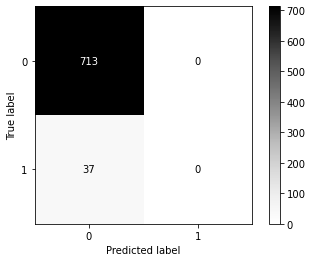

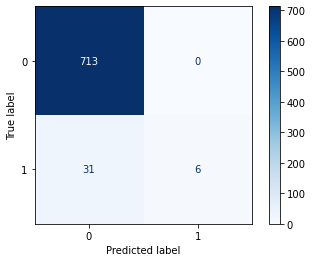

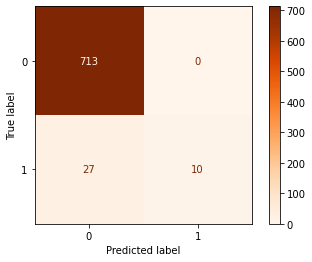

In [11]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix 

plot_confusion_matrix(logRes, X_test, y_test, cmap=plt.cm.Greys)
plot_confusion_matrix(svc_classifier, X_test.toarray(), y_test, cmap=plt.cm.Blues)
plot_confusion_matrix(rf, X_test, y_test, cmap=plt.cm.Oranges)

We can see the matrices in order
- Logistic Regression
- SVM
- Random Forest

We can now use the classification report function to get f1 score, precision and recall values

In [12]:
from sklearn.metrics import classification_report

lr_pred = logRes.predict(X_test)
rf_pred = rf.predict(X_test_arr)
svc_pred = svc_classifier.predict(X_test_arr)
print("Logistic Regression")
print(classification_report(y_test, lr_pred))
print("--------------------")
print("Random Forest")
print(classification_report(y_test, rf_pred))
print("--------------------")
print("Support Vector Machine")
print(classification_report(y_test, svc_pred))
print("--------------------")

Logistic Regression
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       713
           1       0.00      0.00      0.00        37

    accuracy                           0.95       750
   macro avg       0.48      0.50      0.49       750
weighted avg       0.90      0.95      0.93       750

--------------------
Random Forest
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       713
           1       1.00      0.27      0.43        37

    accuracy                           0.96       750
   macro avg       0.98      0.64      0.70       750
weighted avg       0.97      0.96      0.95       750

--------------------
Support Vector Machine
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       713
           1       1.00      0.16      0.28        37

    accuracy                           0.96       750
   macro avg       0.98      

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Cross Validation and Hyper-param tuning

To verify we have the best possible results, we can perform some hyper param tuning and see if it can assist us. We will use GridSearchCV and RepeatedKFold methods to achieve the 10-fold CV. We can use the scores to get the ideal value of a key parameter by minimizing Misclassification Error (or improving Cross Validation score since they are inversely proportional)

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
# define search
search = GridSearchCV(LogisticRegression(), space, scoring='accuracy', n_jobs=-1, cv=cv)
# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)